In [1]:
import pandas as pd
import os

from sklearn.model_selection import train_test_split

import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator, load_img

Using TensorFlow backend.


In [3]:
import random
import matplotlib.pyplot as plt

In [4]:
filenames = os.listdir("train")

In [5]:
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append('dog')
    else:
        categories.append('cat')

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [6]:
df.head()

,filename,category
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat


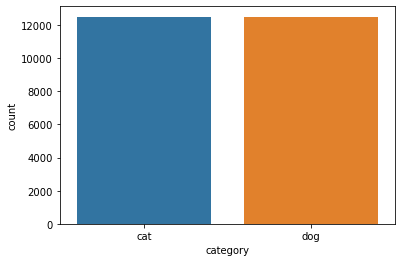

In [7]:
sns.countplot(x='category', data=df)

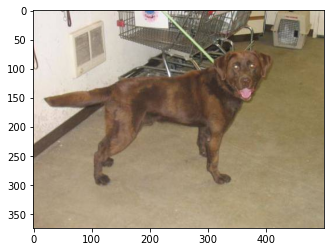

In [8]:
sample = random.choice(filenames)
image = load_img("./train/"+sample)
plt.imshow(image)


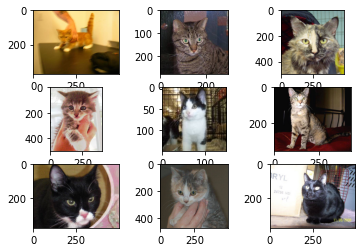

In [9]:
plt.figure('visualize original depth images')
for i, item in enumerate(filenames[0:9]):
    img = load_img("./train/"+item)
    plt.subplot(3,3,i+1)
    plt.imshow(img)
plt.show()   

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>


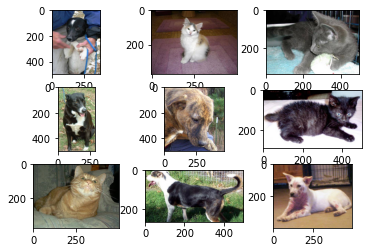

In [10]:
filenames_test = os.listdir("test")
plt.figure('visualize original depth images')
for i, item in enumerate(filenames_test[0:9]):
    img = load_img("./test/"+item)
    print(type(img))
    plt.subplot(3,3,i+1)
    plt.imshow(img)
plt.show()

In [11]:
# import numpy as np
# np.array(img).shape

In [12]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization


In [13]:

IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [14]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)       

In [15]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [16]:
earlystop = EarlyStopping(patience=10)

In [17]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [18]:
callbacks = [earlystop, learning_rate_reduction]

In [19]:
# df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 
# df.head()

In [20]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

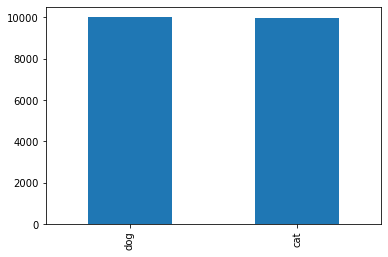

In [21]:
train_df['category'].value_counts().plot.bar()

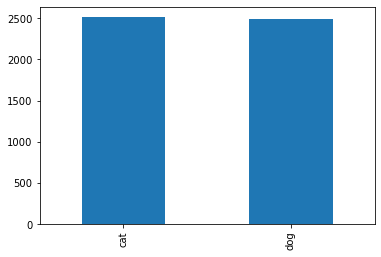

In [22]:
validate_df['category'].value_counts().plot.bar()

In [26]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15
print(f"{total_train}   {total_validate}  {batch_size}")

20000   5000  15


In [28]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [34]:
print(type(train_generator))

<class 'keras.preprocessing.image.DataFrameIterator'>


In [29]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [31]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "./train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


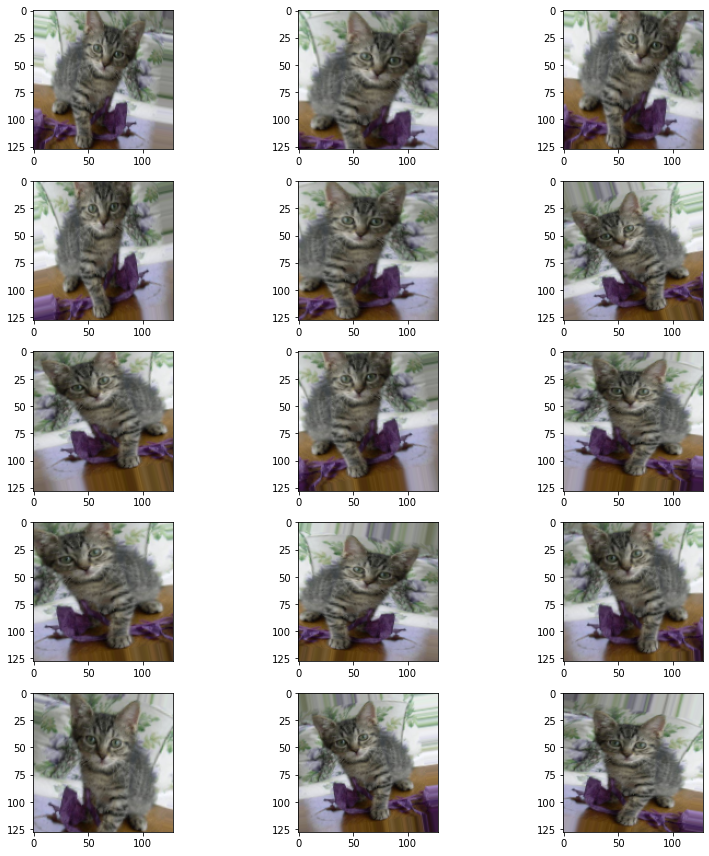

In [32]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [33]:
FAST_RUN = True
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/3
 116/1333 [=>............................] - ETA: 31:10 - loss: 1.2399 - accuracy: 0.5615

KeyboardInterrupt: 